# 3

## Social Network Ads

In [1]:
### Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC

import warnings
warnings.filterwarnings('ignore')

In [3]:
sna_Df = pd.read_csv("C:/Users/HP/Documents/ML/Py_Dataset/datasets_Social_Network_Ads.csv")
sna_Df2 = sna_Df.copy()
sna_Df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In this exercise the author will attempt to model a Classifier that will predict the purchasing outcome based on Social Media Ads, in this case our `target` variable will be `Purchased`.

In [4]:
## Data Description, first let's drop 'User Id'
sna_Df.drop(columns = 'User ID', inplace = True)
print(sna_Df.describe(), '\n')
print(sna_Df['Gender'].value_counts())

              Age  EstimatedSalary   Purchased
count  400.000000       400.000000  400.000000
mean    37.655000     69742.500000    0.357500
std     10.482877     34096.960282    0.479864
min     18.000000     15000.000000    0.000000
25%     29.750000     43000.000000    0.000000
50%     37.000000     70000.000000    0.000000
75%     46.000000     88000.000000    1.000000
max     60.000000    150000.000000    1.000000 

Female    204
Male      196
Name: Gender, dtype: int64


In [5]:
# Check for missing values
for col in sna_Df.columns:
    if sna_Df[col].isnull().any():
        print(col)
    else:
        print('{} _Column is clean'.format(col))

Gender _Column is clean
Age _Column is clean
EstimatedSalary _Column is clean
Purchased _Column is clean


### Data Visualization

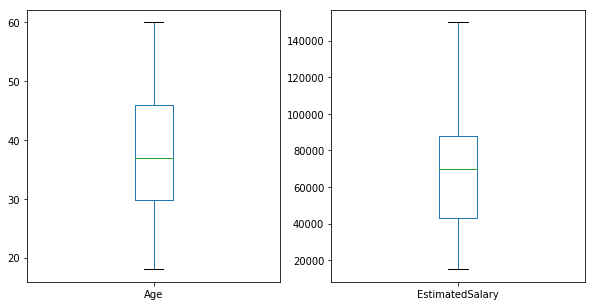

In [6]:
# Box and Whisker Plots
sna_Df.drop(columns = 'Purchased').plot(kind = 'box', subplots = True, figsize = (10,5), 
            sharex = False, sharey = False)
#f, ax = plt.subplots(figsize = (20, 20))
plt.show()

In [7]:
purchased = sna_Df['Purchased'] == 1

cont_features = list(sna_Df.drop(columns = 'Purchased').
                     select_dtypes(exclude = 'object').columns)

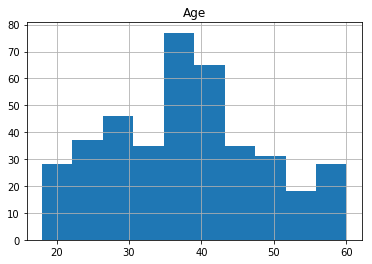

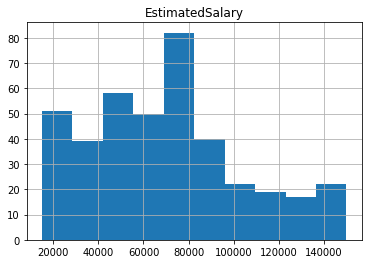

In [8]:
for i in cont_features:
    sna_Df[i].hist()
    plt.title(i)
    plt.show()

Age particularly seem to follow a normal distribution, one way to also examine the dataset is to use `distplot` for continuous variables.

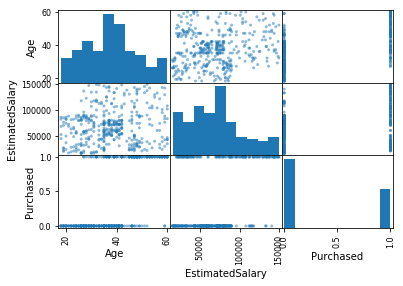

In [9]:
from pandas import scatter_matrix
scatter_matrix(sna_Df)
plt.show()

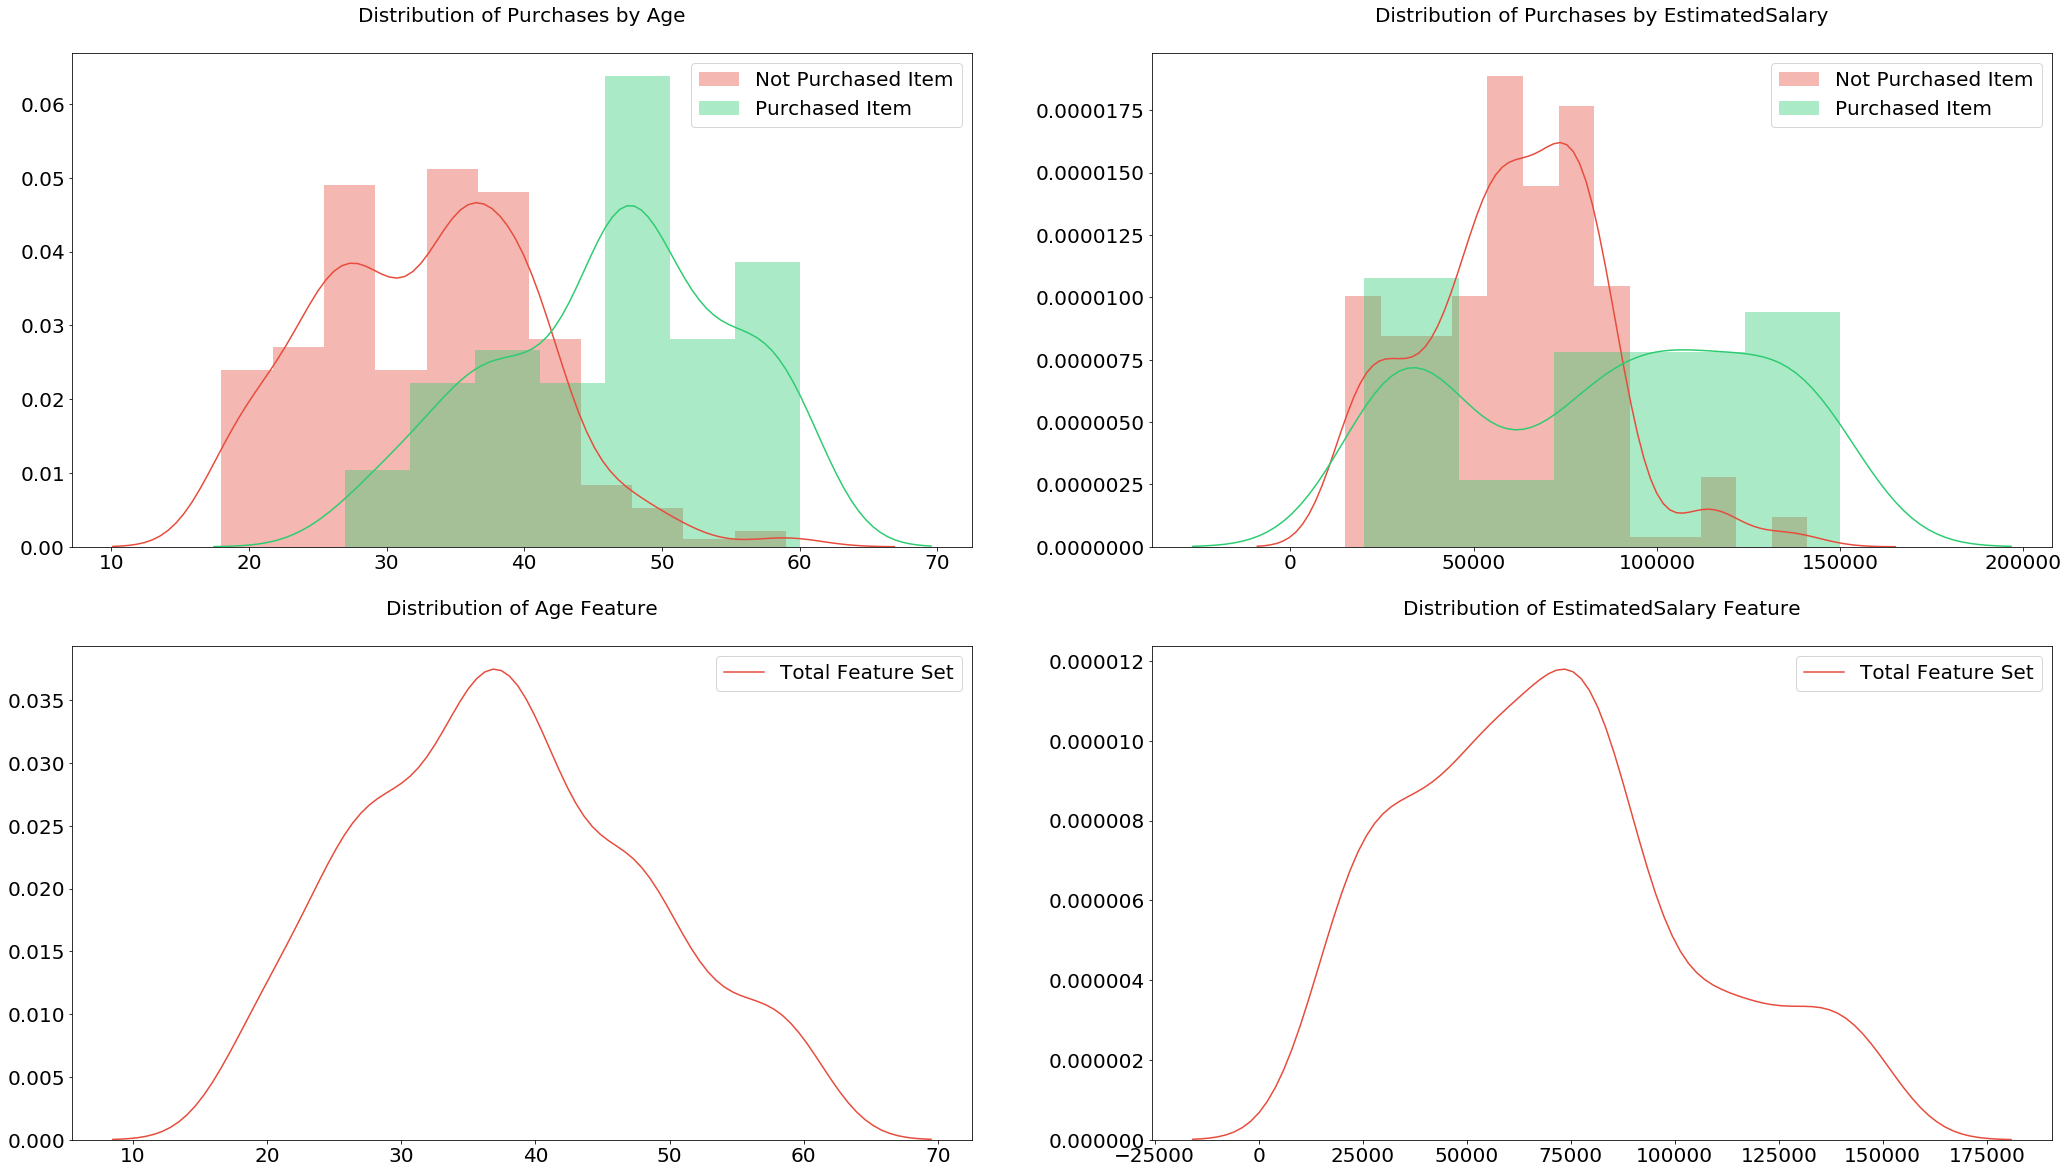

In [10]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (20, 20))
plt.subplots_adjust(right = 1.5)

for i, feature in enumerate(cont_features):
    # Target Distribution
    sns.distplot(sna_Df[~purchased][feature],
                label = "Not Purchased Item", hist = True,
                color = "#e74c3c", ax = axs[0][i])
    sns.distplot(sna_Df[purchased][feature],
                label = "Purchased Item", hist = True,
                color = "#2ecc71",ax = axs[0][i])
    # Feature Distribution
    sns.distplot(sna_Df[feature],
                label = "Total Feature Set", hist = False,
                color = "#e74c3c", ax = axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize = 20)
        axs[i][j].tick_params(axis='y', labelsize = 20)
        
    axs[0][i].legend(loc = 'upper right',prop = {'size':20})
    axs[1][i].legend(loc = 'upper right',prop = {'size':20})
    axs[0][i].set_title('Distribution of Purchases by {}'.
                        format(feature), size = 20, y = 1.05)
    
axs[1][0].set_title('Distribution of {} Feature'.
                    format(cont_features[0]), size = 20, y = 1.05)
axs[1][1].set_title('Distribution of {} Feature'.
                    format(cont_features[1]), size = 20, y = 1.05)

plt.show()

Quite Insightful Graph, we see the divergence in the dataset that determines purchases; In Age the older the more the purchases and quite normally distributed, however in the Est.Salary section we find a wierd decline in sales for those earning about 50000 or so, otherwise the higher the income the higher our purchases. This could be because the population lies more at the lower side of income ....

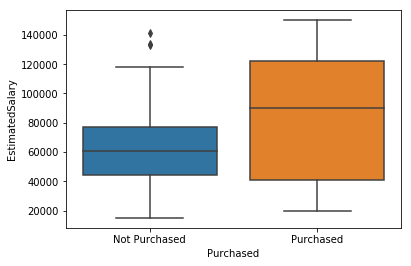

In [11]:
sns.boxplot(x="Purchased", 
            y="EstimatedSalary", 
            data=sna_Df)
plt.xticks((0,1),['Not Purchased', 'Purchased'])
plt.show()

Our Boxplot, gives us a more insight, that the bulk of non-purchases are within a certain cohort of EstimatedSalary.

In [12]:
# Encode Categorical Data

In [13]:
sna_Df['Gender'].value_counts()

Female    204
Male      196
Name: Gender, dtype: int64

In [14]:
dummies = pd.get_dummies(sna_Df2['Gender'], prefix='Gender')
sna_Df2 = sna_Df2.drop(columns = 'Gender').join(dummies)
#Reorder columns
sna_Df2 = sna_Df2[['Age','EstimatedSalary',
                   'Gender_Male','Gender_Female','Purchased']]
sna_Df2.head()

,Age,EstimatedSalary,Gender_Male,Gender_Female,Purchased
0,19,19000,1,0,0
1,35,20000,1,0,0
2,26,43000,0,1,0
3,27,57000,0,1,0
4,19,76000,1,0,0


## Split DataSet

In [15]:
sna_Df2.columns

Index(['Age', 'EstimatedSalary', 'Gender_Male', 'Gender_Female', 'Purchased'], dtype='object')

In [16]:
array = sna_Df2.values #Makes Data Processing faster
array.shape

(400, 5)

In [17]:
X = array[:, 0:4]
y = array[:, 4]

In [18]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y,
                                                               test_size = 0.2, stratify = y,
                                                               random_state = 123)

#Trying out Pipelines

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

pipe = Pipeline([('scalar', StandardScaler()),('svc', SVC())])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [20]:
p = pipe.predict(X_validation)

val_accuracy = accuracy_score(y_validation, p)

print('Model Accuracy Score: {0:0.4f}'.format(val_accuracy))

Model Accuracy Score: 0.9000


In [21]:
?set_params

Object `set_params` not found.


Visualizing our Data

In [22]:
train_X = pd.DataFrame(X_train).rename(columns = {0:'Age',1:'EstSal',
                                                 2:'Male', 3:'Female'})
train_Df = pd.concat([train_X, pd.DataFrame(y_train)], 
                     axis = 1, join = 'inner').rename(columns = {0:"Purchases"})


validation_X = pd.DataFrame(X_validation).rename(columns = {0:'Age',1:'EstSal',
                                                 2:'Male', 3:'Female'})
validation_Df = pd.concat([validation_X, pd.DataFrame(y_validation)], 
                     axis = 1, join = 'inner').rename(columns = {0:"Purchases"})

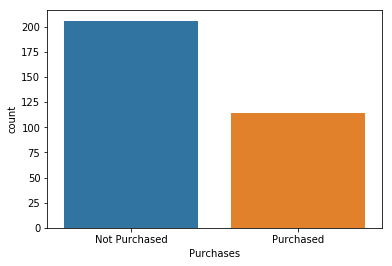

In [23]:
sns.countplot(train_Df['Purchases'], label = 'count')
plt.xticks((0,1),['Not Purchased', 'Purchased'])
plt.show()

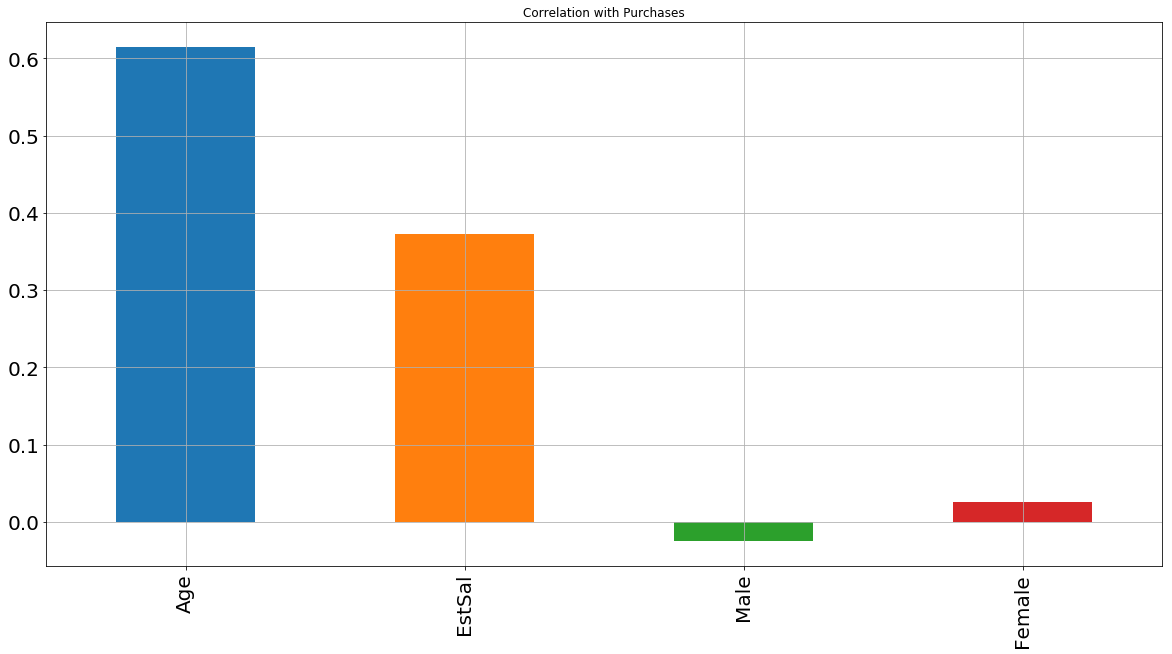

In [24]:
train_Df.drop(columns = 'Purchases').corrwith(train_Df['Purchases']).plot.bar(figsize = (20, 10),
                      title = "Correlation with Purchases",
                      fontsize = 20, rot = 90, grid = True)
plt.show()

With the above result we can see a good correlation of the Age and EstSal features to target variable then only minimally if the customer is female, alternatively if the customer is Male the relationship is negative. Our encoding is paying off and this gives us more insight into what type of product is been advertised, perphas they are hair products, perfumes, etc that women typically purchase.

Next we will examine how these features correlate with each other.

### Cross Correlation within our Features

In [25]:
corrs = pd.DataFrame(train_X).corr().abs().unstack().sort_values(kind = "quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']].sort_values(by= 0)[::-1]
corrs[corrs[0] != 1]

,level_0,level_1,0
9,EstSal,Age,0.176969
8,Age,EstSal,0.176969
7,Female,Age,0.069792
6,Male,Age,0.069792
5,Age,Female,0.069792
4,Age,Male,0.069792
3,Female,EstSal,0.030003
2,Male,EstSal,0.030003
1,EstSal,Female,0.030003
0,EstSal,Male,0.030003


That is interesting.. the sexes seem to corrrelate the same with every other variable, let's check its ditribution.

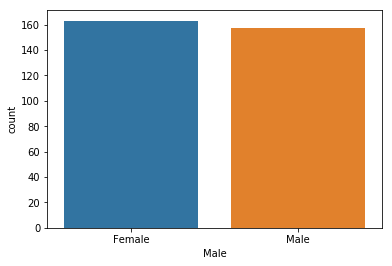

In [26]:
sns.countplot(train_Df['Male'], label = 'count')
plt.xticks((0,1),['Female', 'Male'])
plt.show()

We see they are mostly equally distributed in our dataset, and we only begin to see their marginal difference in how they purchase ads.

### Feature Scaling and Model Revision

In [27]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_validation_scaled = sc_X.fit_transform(X_validation)

Tricky: Depending on the `random_state`, KNN, SVM(~NuSVM), are the most potent models,  given they are all suitable for a Binary Classifier, we will be examining these various models then finally pick the best Classifier.

#### Model Revision: Spot Checking Algorithms

In [28]:
models = []
models.append(('LR', LogisticRegression(solver = 'liblinear', 
                                        multi_class = 'ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RFC', RandomForestClassifier()))
models.append(('SVM', SVC(gamma = 'auto')))
models.append(('NuSVM', NuSVC(gamma = 'auto')))

## Evaluating each model
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: [mean]%f [std](%f) [Diff]%f' % (name, cv_results.mean(), 
                                      cv_results.std(), (cv_results.mean()-cv_results.std())))

LR: [mean]0.628134 [std](0.033985) [Diff]0.594149
KNN: [mean]0.799551 [std](0.074251) [Diff]0.725300
CART: [mean]0.864556 [std](0.054379) [Diff]0.810176
GNB: [mean]0.877560 [std](0.060566) [Diff]0.816993
RFC: [mean]0.899743 [std](0.063108) [Diff]0.836635
SVM: [mean]0.681296 [std](0.038297) [Diff]0.642999
NuSVM: [mean]0.681094 [std](0.048234) [Diff]0.632860


# APPLYING RandomForestClassifier

In [33]:
?RandomForestClassifier

## Grid Search for the Best Parameters

In [38]:
rfc = RandomForestClassifier()

parameter_grid = {'criterion' : ['gini','entropy'],
                 'max_depth' : [5, 7, 9],
                 'min_samples_split' : [5, 7, 9],
                 'n_estimators' : ['warn', 100, 500, 1000, 1500, 2050, 3100]}

grid_search = GridSearchCV(rfc, param_grid = parameter_grid, 
                           cv = kfold, scoring = 'roc_auc')

grid_search.fit(X_train, y_train)

print("Best Score: {:.5f}".format(grid_search.best_score_))
print("Best Parameters: {}".format(grid_search.best_params_))

Best Score: 0.95287
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}


In [39]:
rfc = RandomForestClassifier(criterion = 'entropy', n_estimators = 1000, 
                             max_depth = 5, min_samples_split = 5)

In [43]:
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_validation)

In [44]:
print(accuracy_score(y_validation, predictions), '\n')
print(confusion_matrix(y_validation, predictions), '\n')
print(classification_report(y_validation, predictions))

0.925 

[[48  3]
 [ 3 26]] 

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        51
           1       0.90      0.90      0.90        29

   micro avg       0.93      0.93      0.93        80
   macro avg       0.92      0.92      0.92        80
weighted avg       0.93      0.93      0.93        80



Our model performed wonderfully.